# Deep Ensemble learning: Stacking results from deep learning models

# Outline
* **1. Introduction**

    * 1.1 Loading Libraries

* **2. Data preparation**

    * 2.1 Load Data, Metadata, and Preprocess for Each Model
    
    * 2.2 Exploratory Data Analysis
    
    * 2.3 Feature Extraction

* **3. Training & Validating**

    * 3.1 Split Test/Valid dataset
    
    * 3.2 Classifiers
    
    * 3.3 Models Evaluation
    
    * 3.4 Ensemble models

* **4. Testing model's performance**

    * 4.1 Confusion Matrix and Precision-Recall
    
    * 4.2 Results Summary

# **1. Introduction**


### This code is specifically written for [GRAB AI for S.E.A challenge](https://www.aiforsea.com/).

This is a full walkthrough for building the ensemble learning model for car image dataset provided by [AI Stanford University](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). For this competition, I implemented stacked ensemble machine learning, which the outputs from 5 well-known Deep Learning architectures (Inception, Xception, Resnet50, VGG19, and InceptionResnet) are stacked together and used it as the input for new neural networks. You can check more info about stacked ensemble machine learning [HERE](https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/). First, I will prepare the data (Car images), get prediction for each models (InceptionV3, Xception, VGG, Xception, and InceptionResnet), and combine each results from the model and feed the output as an input into final neural networks model.

Special thanks to Hyungsuk Kang from Kaggle for his [Kernel](https://www.kaggle.com/sudosudoohio/eda-deep-learning-ensemble/data) which I adopted some of his code into this code (of course with adjustments).

## 1.1 Loading Libraries

In this comppetition, I used Keras with Tensorflow backend.

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Dropout, Lambda, Reshape, Flatten
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import cv2
from keras.applications.inception_v3 import preprocess_input as inception_v3_pre
from keras.applications.resnet50 import preprocess_input as resnet50_pre
from keras.applications.vgg19 import preprocess_input as vgg19_pre
from keras.applications.xception import preprocess_input as xception_pre
from keras.applications.inception_resnet_v2 import preprocess_input as InceptionResNetV2_pre
from keras.models import load_model

import matplotlib.image as mpimg
import seaborn as sns
from scipy.io import loadmat
np.random.seed(2)

# 2. Data Preparation

## 2.1. Load Data, Metadata, and Preprocess data for Each Model

Each model requires certain image pixel size and  image diferent preprocesses

### Set up file links and metadata

In [16]:
# Setup Input folder link and image sizes
from pathlib import Path

folder = 'input/'
devkit_path = Path(folder + 'devkit/')
cars_meta = loadmat(devkit_path/'cars_meta.mat')
train_path = Path(folder + 'cars_train/')
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
test_path = Path(folder + 'cars_test/')
cars_test_annos = loadmat(devkit_path/'cars_test_annos_withlabels.mat')

img_path = folder
im_width = 299
im_heigth = 299
im_chan = 3

In [17]:
# Retreiving Class ids and names

frame1 = [[i.flat[0] for i in line] for line in cars_meta['class_names'][0]]
columns1 = ['names']
df_train1 = pd.DataFrame(frame1, columns=columns1)
df_train1.head()
df_train1.tail()

,names
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007
195,smart fortwo Convertible 2012


### Set up metadata for Training set

In [18]:
# Setup Train set dataframe of metadata with necessary information. Since this code focus on classification, the bounding boxes are excluded.

class_id = []

frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class_id'] = df_train['class_id']-1 # Python indexing starts on zero.
df_train['fname'] = ['input/cars_train/' + f for f in df_train['fname']] #  Appending Path

for i in range (len(df_train['class_id'])):
    f = df_train['class_id'][i]
    class_id.append(df_train1['names'][f])


df_train['class_name'] = [class_id][0]
df_train = df_train.drop(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'], axis = 1) ## Deleting unnecessary infomations
df_train.head()

,class_id,fname,class_name
0,13,input/cars_train/00001.jpg,Audi TTS Coupe 2012
1,2,input/cars_train/00002.jpg,Acura TL Sedan 2012
2,90,input/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,133,input/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,105,input/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


### Set up metadata for Test set

In [19]:
class_id1 = []

frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['class_id'] = df_test['class_id']-1 # Python indexing starts on zero.
df_test['fname'] = ['input/cars_test/' + f for f in df_test['fname']] #  Appending Path

for i in range (len(df_test['class_id'])):
    f = df_test['class_id'][i]
    class_id1.append(df_train1['names'][f])


df_test['class_name'] = [class_id1][0]
df_test = df_test.drop(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'], axis = 1) ## Deleting unnecessary infomations
df_test.head()

,class_id,fname,class_name
0,180,input/cars_test/00001.jpg,Suzuki Aerio Sedan 2007
1,102,input/cars_test/00002.jpg,Ferrari 458 Italia Convertible 2012
2,144,input/cars_test/00003.jpg,Jeep Patriot SUV 2012
3,186,input/cars_test/00004.jpg,Toyota Camry Sedan 2012
4,184,input/cars_test/00005.jpg,Tesla Model S Sedan 2012


### Load Training Images

In [20]:
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from tqdm import tqdm_notebook , tnrange
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.transform import resize

In [21]:
x_imgs = np.zeros((len(df_train), im_heigth, im_width, im_chan), dtype=np.uint8)
y_imgs = np.zeros((len(df_train), 1), dtype=np.uint8)

for n, id_ in tqdm_notebook(enumerate(df_train['fname']), total=len(df_train['fname'])):
    imgs = load_img(df_train['fname'][n])
    imgs = img_to_array(imgs)
    imgs = resize(imgs, (im_width, im_heigth, im_chan), mode='constant', preserve_range=True, anti_aliasing=True)
    x_imgs[n] = imgs
    
    y_imgs[n] = np.int(df_train['class_id'][n])

In [22]:
print("train set x shape :", x_imgs.shape)
print("train set y shape :", y_imgs.shape)

train set x shape : (8144, 299, 299, 3)
train set y shape : (8144, 1)


### Checking if we load the right data.

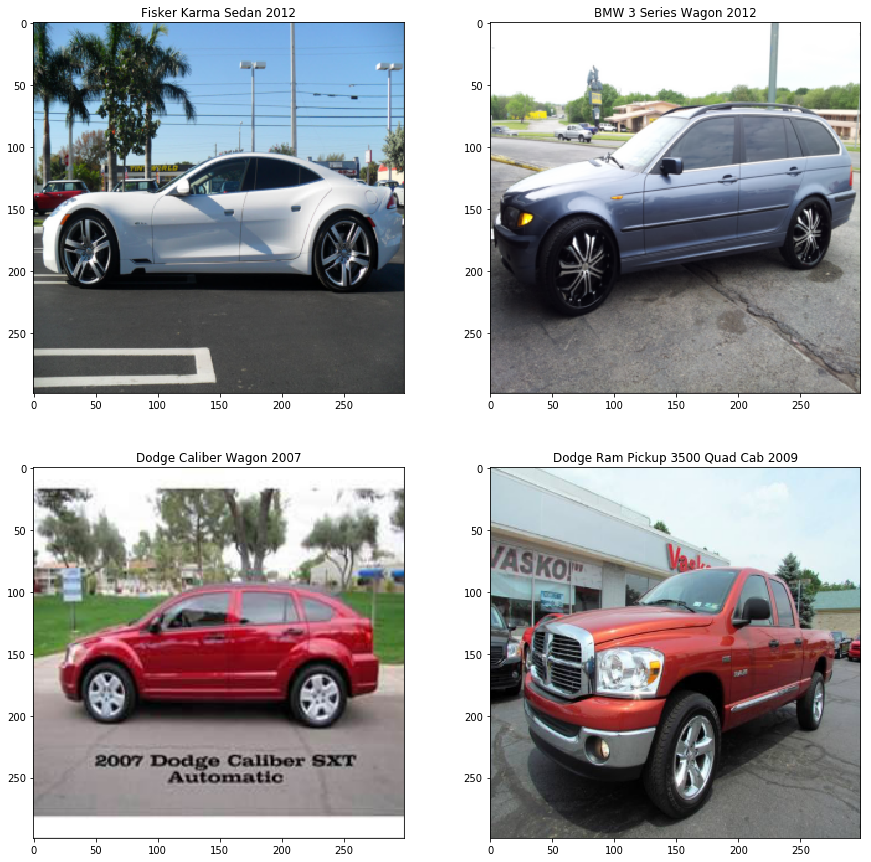

In [96]:
train_sample = x_imgs.shape[0]
rand= np.random.randint(0,train_sample,4)

fig=plt.figure(figsize=(15, 15))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    r = rand[i-1]
    img = x_imgs[r]
    cla_name = df_train['class_name'][r]
    fig.add_subplot(rows, columns, i)
    plt.title(cla_name)
    plt.imshow(img)

plt.show()

### Load Test Images

In [24]:
x_imgs1 = np.zeros((len(df_test), im_heigth, im_width, im_chan), dtype=np.uint8)
y_imgs1 = np.zeros((len(df_test), 1), dtype=np.uint8)

for n, id_ in tqdm_notebook(enumerate(df_test['fname']), total=len(df_test['fname'])):
    imgs1 = load_img(df_test['fname'][n])
    imgs1 = img_to_array(imgs1)
    imgs1 = resize(imgs1, (im_width, im_heigth, im_chan), mode='constant', preserve_range=True, anti_aliasing=True)
    x_imgs1[n] = imgs1
    
    y_imgs1[n] = np.int(df_test['class_id'][n])

In [25]:
print("test set x shape :", x_imgs1.shape)
print("test set y shape :", y_imgs1.shape)

test set x shape : (8041, 299, 299, 3)
test set y shape : (8041, 1)


### Checking if we load the right data.

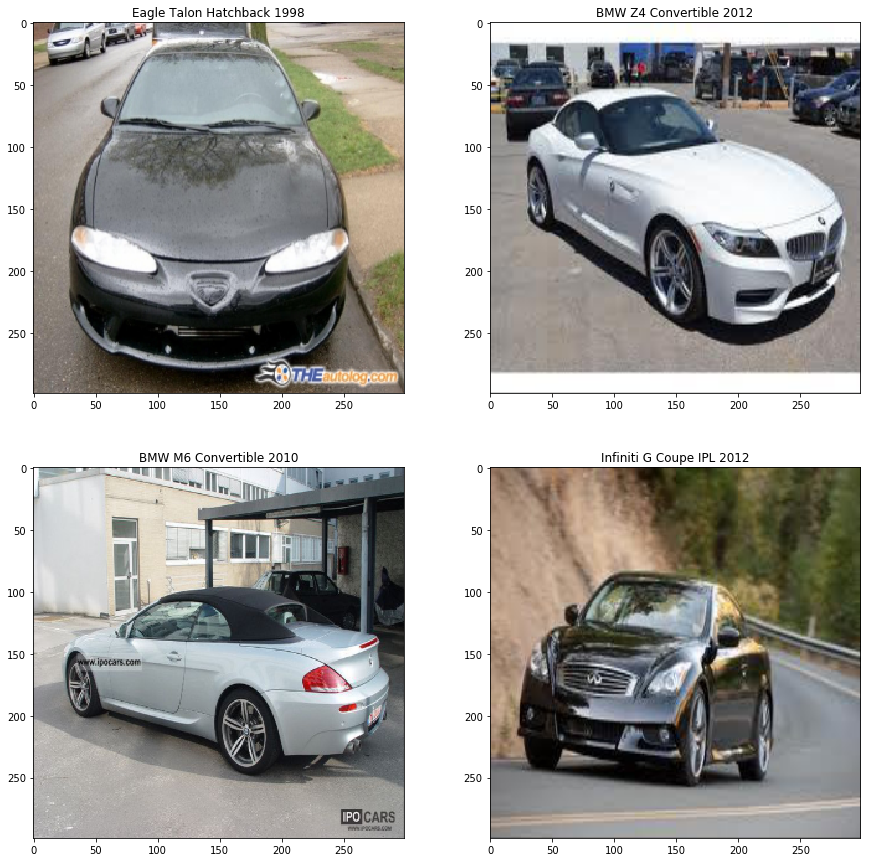

In [95]:
test_sample = x_imgs1.shape[0]
rand1= np.random.randint(0,test_sample,4)

fig1=plt.figure(figsize=(15, 15))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    r = rand1[i-1]
    img1 = x_imgs1[r]
    cla_name1 = df_test['class_name'][r]
    fig1.add_subplot(rows, columns, i)
    plt.title(cla_name1)
    plt.imshow(img1)

plt.show()

## 2.2 Exploratory Data Analysis

### Distribution of Output Variable

In [27]:
# Checking the class frequency

freq_labels = df_train.groupby('class_name').count()[['class_id']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='class_id', ascending=False)
freq_labels.head(10)

,class_id
class_name,
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mercedes-Benz 300-Class Convertible 1993,48
Mitsubishi Lancer Sedan 2012,48
Jaguar XK XKR 2012,47
Chevrolet Corvette ZR1 2012,47
Audi S6 Sedan 2011,46
Volkswagen Golf Hatchback 1991,46
Ford GT Coupe 2006,46


In [28]:
freq_labels.to_csv(r'cars_count.csv', header = True)

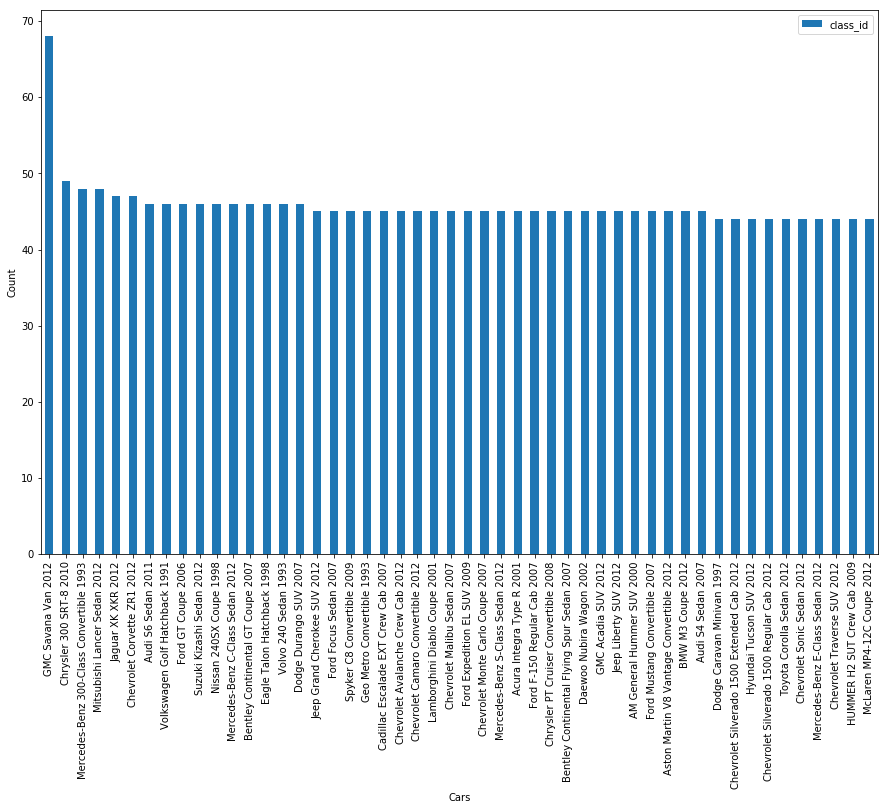

In [29]:
freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");

In [30]:
from collections import Counter

print('The data set is imbalanced: {}'.format(Counter(df_train['class_id'])))

The data set is imbalanced: Counter({118: 68, 78: 49, 166: 48, 160: 48, 143: 47, 55: 47, 193: 46, 190: 46, 42: 46, 19: 46, 111: 46, 161: 46, 170: 46, 181: 46, 97: 46, 94: 46, 122: 45, 72: 45, 147: 45, 52: 45, 43: 45, 64: 45, 113: 45, 7: 45, 58: 45, 164: 45, 120: 45, 146: 45, 108: 45, 178: 45, 23: 45, 0: 45, 5: 45, 71: 45, 106: 45, 152: 45, 114: 45, 80: 45, 33: 45, 81: 45, 88: 44, 57: 44, 84: 44, 171: 44, 169: 44, 104: 44, 176: 44, 172: 44, 186: 44, 93: 44, 187: 44, 144: 44, 73: 44, 136: 44, 75: 44, 107: 44, 124: 44, 159: 44, 15: 44, 62: 44, 131: 44, 30: 44, 45: 44, 150: 44, 86: 44, 74: 44, 163: 44, 13: 43, 2: 43, 191: 43, 119: 43, 85: 43, 179: 43, 153: 43, 138: 43, 103: 43, 14: 43, 189: 43, 28: 43, 109: 43, 17: 43, 50: 43, 60: 43, 154: 43, 148: 43, 47: 43, 194: 43, 21: 43, 112: 43, 116: 43, 69: 43, 145: 43, 79: 43, 105: 42, 134: 42, 192: 42, 65: 42, 132: 42, 96: 42, 100: 42, 110: 42, 125: 42, 130: 42, 177: 42, 139: 42, 29: 42, 49: 42, 182: 42, 83: 42, 167: 42, 20: 42, 31: 42, 3: 42, 11

It can be seen that:
    
    - Label samples are biased to some labels.
    - Balancing weight for each class may improve LB score.

In [31]:
from sklearn.utils.class_weight import compute_class_weight

#y_integers = np.argmax(y_train1, axis=1)
class_weights = compute_class_weight('balanced', np.unique(df_train['class_id']), df_train['class_id'])
class_weights = dict(enumerate(class_weights))

## 2.3 Feature Extraction

### Extract Bottleneck Features for Train and Test Data


As metioned before, every model have their own types of data. Therefore, different data are created for each model.
Function from [Yang Peiwan's kernel](https://www.kaggle.com/yangpeiwen/keras-inception-xception-0-47) with modifications:

In [32]:
def get_features(MODEL, data, batch_size, preprocess):
    
    cnn_model = MODEL(include_top=False, input_shape=(im_width, im_heigth, im_chan), weights='imagenet')
    
    inputs = Input((im_width, im_heigth, im_chan))
    x = inputs
    x = Lambda(preprocess, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=batch_size, verbose=1)
    return features### InceptionV3

### InceptionV3

In [33]:
inception_train_features = get_features(InceptionV3, x_imgs, 32, inception_v3_pre)
inception_test_features = get_features(InceptionV3, x_imgs1, 32, inception_v3_pre)

8041/8041 [==============================] - ETA: 17:1 - ETA: 9:0 - ETA: 6: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - E

### Xception

In [34]:
xception_train_features = get_features(Xception, x_imgs, 32, xception_pre)
xception_test_features = get_features(Xception, x_imgs1, 32, xception_pre)

8041/8041 [==============================] - ETA: 18:4 - ETA: 10:1 - ETA: 7:2 - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - 

### Resnet50

In [35]:
resnet_train_features = get_features(ResNet50, x_imgs, 32, resnet50_pre)
resnet_test_features = get_features(ResNet50, x_imgs1, 32, resnet50_pre)

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


8144/8144 [==============================] - ETA: 27:3 - ETA: 14:2 - ETA: 10:0 - ETA: 7:5 - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: 

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


8041/8041 [==============================] - ETA: 26:5 - ETA: 14:0 - ETA: 9:5 - ETA: 7: - ETA: 6: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - 

### InceptionResNetV2

In [36]:
inceptionresnet_train_features = get_features(InceptionResNetV2, x_imgs, 32, InceptionResNetV2_pre)
inceptionresnet_test_features = get_features(InceptionResNetV2, x_imgs1, 32, InceptionResNetV2_pre)

8041/8041 [==============================] - ETA: 1:20:2 - ETA: 41:05  - ETA: 27:5 - ETA: 21:2 - ETA: 17:2 - ETA: 14:5 - ETA: 12:5 - ETA: 11:3 - ETA: 10:2 - ETA: 9:3 - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ET

### VGG19

In [37]:
vgg_train_features = get_features(VGG19, x_imgs, 32, vgg19_pre)
vgg_test_features = get_features(VGG19, x_imgs1, 32, vgg19_pre)

8041/8041 [==============================] - ETA: 31:0 - ETA: 16:2 - ETA: 11:3 - ETA: 9:0 - ETA: 7: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: 

# 3. Training/Validating Pipeline

## 3.1. Split Test/Valid dataset

### Split test data for model validation and testing, with 40% validation and 60% testing

In [38]:
from keras.utils import to_categorical

y_train = to_categorical(df_train['class_id'])
y_test = to_categorical(df_test['class_id'])

In [39]:
X_valid_xception, X_test_xception, y_valid_xception, y_test_xception =  train_test_split(xception_test_features, y_test, test_size=0.6, random_state=99)
X_valid_inception, X_test_inception, y_valid_inception, y_test_inception = train_test_split(inception_test_features, y_test, test_size=0.6, random_state=99)
X_valid_vgg, X_test_vgg, y_valid_vgg, y_test_vgg = train_test_split(vgg_test_features, y_test, test_size=0.6, random_state=99)
X_valid_resnet, X_test_resnet, y_valid_resnet, y_test_resnet = train_test_split(resnet_test_features, y_test, test_size=0.6, random_state=99)
X_valid_inceptionresnet, X_test_inceptionresnet, y_valid_inceptionresnet, y_test_inceptionresnet = train_test_split(inceptionresnet_test_features, y_test, test_size=0.6, random_state=99)

In [40]:
print("x train shape :", inception_train_features.shape[0])
print("x valid shape :", X_valid_xception.shape[0])
print("x test shape :", X_test_xception.shape[0])
print("y train shape :", y_train.shape[0])
print("y valid shape :", y_valid_xception.shape[0])
print("y train shape :", y_test_xception.shape[0])

x train shape : 8144
x valid shape : 3216
x test shape : 4825
y train shape : 8144
y valid shape : 3216
y train shape : 4825


## If you want to Test the trained model, skip 3.2 and move to 3.4

Since I provided the trained model for all Inception, Xception, VGG19, Resnet50, InceptionResnet, and the Ensemble Model. You can skip this part. All the save model are in folder save_models

## 3.2. Classifiers


### Neural Net

In [41]:
n_class = 196

Inception_model = Sequential()
Inception_model.add(Dense(512, activation='relu', input_shape=inception_train_features.shape[1:]))
Inception_model.add(Dropout(0.2))
Inception_model.add(Dense(n_class, activation='softmax'))

Inception_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Inception_model.summary()


Xception_model = Sequential()
Xception_model.add(Dense(512, activation='relu', input_shape=xception_train_features.shape[1:]))
Xception_model.add(Dropout(0.2))
Xception_model.add(Dense(n_class, activation='softmax'))

Xception_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Xception_model.summary()


VGG_model = Sequential()
VGG_model.add(Dense(512, activation='relu', input_shape=vgg_train_features.shape[1:]))
VGG_model.add(Dropout(0.2))
VGG_model.add(Dense(n_class, activation='softmax'))

VGG_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'], 
           )

VGG_model.summary()

Resnet_model = Sequential()
Resnet_model.add(Dense(512, activation='relu', input_shape=resnet_train_features.shape[1:]))
Resnet_model.add(Dropout(0.2))
Resnet_model.add(Dense(n_class, activation='softmax'))

Resnet_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Resnet_model.summary()

InceptionResnet_model = Sequential()
InceptionResnet_model.add(Dense(512, activation='relu', input_shape=inceptionresnet_train_features.shape[1:]))
InceptionResnet_model.add(Dropout(0.2))
InceptionResnet_model.add(Dense(n_class, activation='softmax'))

InceptionResnet_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

InceptionResnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               100548    
Total params: 1,149,636
Trainable params: 1,149,636
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________


### Callbacks

- ModelCheckpoint is used to get the best model after epochs

- ReduceLROnPlateau is used to manipulate learning rate for more delciate correction

- EarlyStopping stop the model if there is no improvement to validation loss. This is to avoid model overfit and wasting time.

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min',patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode = 'min',factor=0.5, patience=50, min_lr=0.00001, verbose=1)

inception_callbacks=[TQDMNotebookCallback(),
                     reduce_lr,
                      ModelCheckpoint(filepath='saved_models/inception.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                     early_stopping
                     ]

xception_callbacks=[TQDMNotebookCallback(),
                    reduce_lr,
                      ModelCheckpoint(filepath='saved_models/xception.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                    early_stopping
                     ]

resnet_callbacks=[TQDMNotebookCallback(),
                    reduce_lr,
                    ModelCheckpoint(filepath='saved_models/resnet.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                  early_stopping
                     ]

vgg_callbacks=[TQDMNotebookCallback(),
                reduce_lr,
                ModelCheckpoint(filepath='saved_models/vgg.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
               early_stopping
                     ]

inceptionresnet_callbacks=[TQDMNotebookCallback(),
                reduce_lr,
                ModelCheckpoint(filepath='saved_models/inceptionresnet.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
               early_stopping
                     ]

In [43]:
epochs = 1000 # Increase this if you want more accurate results(It is recommended to run on personal computer in this case)

inception_history = Inception_model.fit(inception_train_features, y_train, 
          validation_data=(X_valid_inception, y_valid_inception),
          epochs=epochs, 
          callbacks=inception_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

xception_history = Xception_model.fit(xception_train_features, y_train, 
          validation_data=(X_valid_xception, y_valid_xception),
          epochs=epochs,                            
          callbacks=xception_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

resnet_history = Resnet_model.fit(resnet_train_features, y_train, 
          validation_data=(X_valid_resnet, y_valid_resnet),
          epochs=epochs, 
          callbacks=resnet_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

vgg_history = VGG_model.fit(vgg_train_features, y_train, 
          validation_data=(X_valid_vgg, y_valid_vgg),
          epochs=epochs, 
          callbacks=vgg_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

inceptionresnet_history = InceptionResnet_model.fit(inceptionresnet_train_features, y_train, 
                        validation_data=(X_valid_inceptionresnet, y_valid_inceptionresnet),
                        epochs=epochs, 
                        callbacks=inceptionresnet_callbacks,
                        class_weight=class_weights,
                        batch_size=32, verbose=0)


Epoch 00001: val_loss improved from inf to 3.66168, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.66168 to 3.27430, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.27430 to 3.00084, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00004: val_loss improved from 3.00084 to 2.80414, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.80414 to 2.71440, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.71440 to 2.58437, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.58437 to 2.50937, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.50937 to 2.43768, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.43768 to 2.39471, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00010: val_loss improved from 2.39471 to 2.36149, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00011: val_loss improved from 2.36149 to 2.30704, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00012: val_loss improved from 2.30704 to 2.28995, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00013: val_loss improved from 2.28995 to 2.27941, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00014: val_loss improved from 2.27941 to 2.21495, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00015: val_loss did not improve from 2.21495



Epoch 00016: val_loss did not improve from 2.21495



Epoch 00017: val_loss improved from 2.21495 to 2.17438, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00018: val_loss did not improve from 2.17438



Epoch 00019: val_loss did not improve from 2.17438



Epoch 00020: val_loss did not improve from 2.17438



Epoch 00021: val_loss did not improve from 2.17438



Epoch 00022: val_loss did not improve from 2.17438



Epoch 00023: val_loss did not improve from 2.17438



Epoch 00024: val_loss did not improve from 2.17438



Epoch 00025: val_loss did not improve from 2.17438



Epoch 00026: val_loss did not improve from 2.17438



Epoch 00027: val_loss did not improve from 2.17438



Epoch 00028: val_loss did not improve from 2.17438



Epoch 00029: val_loss did not improve from 2.17438



Epoch 00030: val_loss did not improve from 2.17438



Epoch 00031: val_loss did not improve from 2.17438



Epoch 00032: val_loss did not improve from 2.17438



Epoch 00033: val_loss did not improve from 2.17438



Epoch 00034: val_loss did not improve from 2.17438



Epoch 00035: val_loss did not improve from 2.17438



Epoch 00036: val_loss did not improve from 2.17438



Epoch 00037: val_loss did not improve from 2.17438



Epoch 00038: val_loss did not improve from 2.17438



Epoch 00039: val_loss did not improve from 2.17438



Epoch 00040: val_loss did not improve from 2.17438



Epoch 00041: val_loss did not improve from 2.17438



Epoch 00042: val_loss did not improve from 2.17438



Epoch 00043: val_loss did not improve from 2.17438



Epoch 00044: val_loss did not improve from 2.17438



Epoch 00045: val_loss did not improve from 2.17438



Epoch 00046: val_loss did not improve from 2.17438



Epoch 00047: val_loss did not improve from 2.17438



Epoch 00048: val_loss did not improve from 2.17438



Epoch 00049: val_loss did not improve from 2.17438



Epoch 00050: val_loss did not improve from 2.17438



Epoch 00051: val_loss did not improve from 2.17438



Epoch 00052: val_loss did not improve from 2.17438



Epoch 00053: val_loss did not improve from 2.17438



Epoch 00054: val_loss did not improve from 2.17438



Epoch 00055: val_loss did not improve from 2.17438



Epoch 00056: val_loss did not improve from 2.17438



Epoch 00057: val_loss did not improve from 2.17438



Epoch 00058: val_loss did not improve from 2.17438



Epoch 00059: val_loss did not improve from 2.17438



Epoch 00060: val_loss did not improve from 2.17438



Epoch 00061: val_loss did not improve from 2.17438



Epoch 00062: val_loss did not improve from 2.17438



Epoch 00063: val_loss did not improve from 2.17438



Epoch 00064: val_loss did not improve from 2.17438



Epoch 00065: val_loss did not improve from 2.17438



Epoch 00066: val_loss did not improve from 2.17438



Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00067: val_loss did not improve from 2.17438



Epoch 00068: val_loss did not improve from 2.17438



Epoch 00069: val_loss did not improve from 2.17438



Epoch 00070: val_loss did not improve from 2.17438



Epoch 00071: val_loss did not improve from 2.17438



Epoch 00072: val_loss did not improve from 2.17438



Epoch 00073: val_loss did not improve from 2.17438



Epoch 00074: val_loss did not improve from 2.17438



Epoch 00075: val_loss did not improve from 2.17438



Epoch 00076: val_loss did not improve from 2.17438



Epoch 00077: val_loss did not improve from 2.17438



Epoch 00078: val_loss did not improve from 2.17438



Epoch 00079: val_loss did not improve from 2.17438



Epoch 00080: val_loss did not improve from 2.17438



Epoch 00081: val_loss did not improve from 2.17438



Epoch 00082: val_loss did not improve from 2.17438



Epoch 00083: val_loss did not improve from 2.17438



Epoch 00084: val_loss did not improve from 2.17438



Epoch 00085: val_loss did not improve from 2.17438



Epoch 00086: val_loss did not improve from 2.17438



Epoch 00087: val_loss did not improve from 2.17438



Epoch 00088: val_loss did not improve from 2.17438



Epoch 00089: val_loss did not improve from 2.17438



Epoch 00090: val_loss did not improve from 2.17438



Epoch 00091: val_loss did not improve from 2.17438



Epoch 00092: val_loss did not improve from 2.17438



Epoch 00093: val_loss did not improve from 2.17438



Epoch 00094: val_loss did not improve from 2.17438



Epoch 00095: val_loss did not improve from 2.17438



Epoch 00096: val_loss did not improve from 2.17438



Epoch 00097: val_loss did not improve from 2.17438



Epoch 00098: val_loss did not improve from 2.17438



Epoch 00099: val_loss did not improve from 2.17438



Epoch 00100: val_loss did not improve from 2.17438



Epoch 00101: val_loss did not improve from 2.17438



Epoch 00102: val_loss did not improve from 2.17438



Epoch 00103: val_loss did not improve from 2.17438



Epoch 00104: val_loss did not improve from 2.17438



Epoch 00105: val_loss did not improve from 2.17438



Epoch 00106: val_loss did not improve from 2.17438



Epoch 00107: val_loss did not improve from 2.17438



Epoch 00108: val_loss did not improve from 2.17438



Epoch 00109: val_loss did not improve from 2.17438



Epoch 00110: val_loss did not improve from 2.17438



Epoch 00111: val_loss did not improve from 2.17438



Epoch 00112: val_loss did not improve from 2.17438



Epoch 00113: val_loss did not improve from 2.17438



Epoch 00114: val_loss did not improve from 2.17438



Epoch 00115: val_loss did not improve from 2.17438



Epoch 00116: val_loss did not improve from 2.17438



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00117: val_loss did not improve from 2.17438
Epoch 00117: early stopping



Epoch 00001: val_loss improved from inf to 3.41933, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.41933 to 3.02545, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.02545 to 2.73783, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00004: val_loss improved from 2.73783 to 2.59254, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.59254 to 2.44330, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.44330 to 2.39321, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.39321 to 2.28675, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.28675 to 2.26769, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.26769 to 2.18084, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00010: val_loss improved from 2.18084 to 2.16341, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00011: val_loss did not improve from 2.16341



Epoch 00012: val_loss did not improve from 2.16341



Epoch 00013: val_loss improved from 2.16341 to 2.13054, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00014: val_loss did not improve from 2.13054



Epoch 00015: val_loss did not improve from 2.13054



Epoch 00016: val_loss improved from 2.13054 to 2.12460, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00017: val_loss did not improve from 2.12460



Epoch 00018: val_loss did not improve from 2.12460



Epoch 00019: val_loss did not improve from 2.12460



Epoch 00020: val_loss did not improve from 2.12460



Epoch 00021: val_loss did not improve from 2.12460



Epoch 00022: val_loss did not improve from 2.12460



Epoch 00023: val_loss did not improve from 2.12460



Epoch 00024: val_loss did not improve from 2.12460



Epoch 00025: val_loss did not improve from 2.12460



Epoch 00026: val_loss did not improve from 2.12460



Epoch 00027: val_loss did not improve from 2.12460



Epoch 00028: val_loss did not improve from 2.12460



Epoch 00029: val_loss did not improve from 2.12460



Epoch 00030: val_loss did not improve from 2.12460



Epoch 00031: val_loss did not improve from 2.12460



Epoch 00032: val_loss did not improve from 2.12460



Epoch 00033: val_loss did not improve from 2.12460



Epoch 00034: val_loss did not improve from 2.12460



Epoch 00035: val_loss did not improve from 2.12460



Epoch 00036: val_loss did not improve from 2.12460



Epoch 00037: val_loss did not improve from 2.12460



Epoch 00038: val_loss did not improve from 2.12460



Epoch 00039: val_loss did not improve from 2.12460



Epoch 00040: val_loss did not improve from 2.12460



Epoch 00041: val_loss did not improve from 2.12460



Epoch 00042: val_loss did not improve from 2.12460



Epoch 00043: val_loss did not improve from 2.12460



Epoch 00044: val_loss did not improve from 2.12460



Epoch 00045: val_loss did not improve from 2.12460



Epoch 00046: val_loss did not improve from 2.12460



Epoch 00047: val_loss did not improve from 2.12460



Epoch 00048: val_loss did not improve from 2.12460



Epoch 00049: val_loss did not improve from 2.12460



Epoch 00050: val_loss did not improve from 2.12460



Epoch 00051: val_loss did not improve from 2.12460



Epoch 00052: val_loss did not improve from 2.12460



Epoch 00053: val_loss did not improve from 2.12460



Epoch 00054: val_loss did not improve from 2.12460



Epoch 00055: val_loss did not improve from 2.12460



Epoch 00056: val_loss did not improve from 2.12460



Epoch 00057: val_loss did not improve from 2.12460



Epoch 00058: val_loss did not improve from 2.12460



Epoch 00059: val_loss did not improve from 2.12460



Epoch 00060: val_loss did not improve from 2.12460



Epoch 00061: val_loss did not improve from 2.12460



Epoch 00062: val_loss did not improve from 2.12460



Epoch 00063: val_loss did not improve from 2.12460



Epoch 00064: val_loss did not improve from 2.12460



Epoch 00065: val_loss did not improve from 2.12460



Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00066: val_loss did not improve from 2.12460



Epoch 00067: val_loss did not improve from 2.12460



Epoch 00068: val_loss did not improve from 2.12460



Epoch 00069: val_loss did not improve from 2.12460



Epoch 00070: val_loss did not improve from 2.12460



Epoch 00071: val_loss did not improve from 2.12460



Epoch 00072: val_loss did not improve from 2.12460



Epoch 00073: val_loss did not improve from 2.12460



Epoch 00074: val_loss did not improve from 2.12460



Epoch 00075: val_loss did not improve from 2.12460



Epoch 00076: val_loss did not improve from 2.12460



Epoch 00077: val_loss did not improve from 2.12460



Epoch 00078: val_loss did not improve from 2.12460



Epoch 00079: val_loss did not improve from 2.12460



Epoch 00080: val_loss did not improve from 2.12460



Epoch 00081: val_loss did not improve from 2.12460



Epoch 00082: val_loss did not improve from 2.12460



Epoch 00083: val_loss did not improve from 2.12460



Epoch 00084: val_loss did not improve from 2.12460



Epoch 00085: val_loss did not improve from 2.12460



Epoch 00086: val_loss did not improve from 2.12460



Epoch 00087: val_loss did not improve from 2.12460



Epoch 00088: val_loss did not improve from 2.12460



Epoch 00089: val_loss did not improve from 2.12460



Epoch 00090: val_loss did not improve from 2.12460



Epoch 00091: val_loss did not improve from 2.12460



Epoch 00092: val_loss did not improve from 2.12460



Epoch 00093: val_loss did not improve from 2.12460



Epoch 00094: val_loss did not improve from 2.12460



Epoch 00095: val_loss did not improve from 2.12460



Epoch 00096: val_loss did not improve from 2.12460



Epoch 00097: val_loss did not improve from 2.12460



Epoch 00098: val_loss did not improve from 2.12460



Epoch 00099: val_loss did not improve from 2.12460



Epoch 00100: val_loss did not improve from 2.12460



Epoch 00101: val_loss did not improve from 2.12460



Epoch 00102: val_loss did not improve from 2.12460



Epoch 00103: val_loss did not improve from 2.12460



Epoch 00104: val_loss did not improve from 2.12460



Epoch 00105: val_loss did not improve from 2.12460



Epoch 00106: val_loss did not improve from 2.12460



Epoch 00107: val_loss did not improve from 2.12460



Epoch 00108: val_loss did not improve from 2.12460



Epoch 00109: val_loss did not improve from 2.12460



Epoch 00110: val_loss did not improve from 2.12460



Epoch 00111: val_loss did not improve from 2.12460



Epoch 00112: val_loss did not improve from 2.12460



Epoch 00113: val_loss did not improve from 2.12460



Epoch 00114: val_loss did not improve from 2.12460



Epoch 00115: val_loss did not improve from 2.12460



Epoch 00116: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00116: val_loss did not improve from 2.12460
Epoch 00116: early stopping



Epoch 00001: val_loss improved from inf to 3.75605, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.75605 to 3.03944, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.03944 to 2.63714, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00004: val_loss improved from 2.63714 to 2.39785, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.39785 to 2.19580, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.19580 to 2.05074, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.05074 to 1.97994, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00008: val_loss improved from 1.97994 to 1.86691, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00009: val_loss improved from 1.86691 to 1.85093, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00010: val_loss improved from 1.85093 to 1.82134, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00011: val_loss improved from 1.82134 to 1.79517, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00012: val_loss improved from 1.79517 to 1.72856, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00013: val_loss improved from 1.72856 to 1.70909, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00014: val_loss did not improve from 1.70909



Epoch 00015: val_loss improved from 1.70909 to 1.70165, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00016: val_loss improved from 1.70165 to 1.69854, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00017: val_loss improved from 1.69854 to 1.69299, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00018: val_loss improved from 1.69299 to 1.68480, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00019: val_loss did not improve from 1.68480



Epoch 00020: val_loss did not improve from 1.68480



Epoch 00021: val_loss did not improve from 1.68480



Epoch 00022: val_loss did not improve from 1.68480



Epoch 00023: val_loss did not improve from 1.68480



Epoch 00024: val_loss did not improve from 1.68480



Epoch 00025: val_loss did not improve from 1.68480



Epoch 00026: val_loss did not improve from 1.68480



Epoch 00027: val_loss did not improve from 1.68480



Epoch 00028: val_loss did not improve from 1.68480



Epoch 00029: val_loss did not improve from 1.68480



Epoch 00030: val_loss did not improve from 1.68480



Epoch 00031: val_loss did not improve from 1.68480



Epoch 00032: val_loss did not improve from 1.68480



Epoch 00033: val_loss did not improve from 1.68480



Epoch 00034: val_loss did not improve from 1.68480



Epoch 00035: val_loss did not improve from 1.68480



Epoch 00036: val_loss did not improve from 1.68480



Epoch 00037: val_loss did not improve from 1.68480



Epoch 00038: val_loss did not improve from 1.68480



Epoch 00039: val_loss did not improve from 1.68480



Epoch 00040: val_loss did not improve from 1.68480



Epoch 00041: val_loss did not improve from 1.68480



Epoch 00042: val_loss did not improve from 1.68480



Epoch 00043: val_loss did not improve from 1.68480



Epoch 00044: val_loss did not improve from 1.68480



Epoch 00045: val_loss did not improve from 1.68480



Epoch 00046: val_loss did not improve from 1.68480



Epoch 00047: val_loss did not improve from 1.68480



Epoch 00048: val_loss did not improve from 1.68480



Epoch 00049: val_loss did not improve from 1.68480



Epoch 00050: val_loss did not improve from 1.68480



Epoch 00051: val_loss did not improve from 1.68480



Epoch 00052: val_loss did not improve from 1.68480



Epoch 00053: val_loss did not improve from 1.68480



Epoch 00054: val_loss did not improve from 1.68480



Epoch 00055: val_loss did not improve from 1.68480



Epoch 00056: val_loss did not improve from 1.68480



Epoch 00057: val_loss did not improve from 1.68480



Epoch 00058: val_loss did not improve from 1.68480



Epoch 00059: val_loss did not improve from 1.68480



Epoch 00060: val_loss did not improve from 1.68480



Epoch 00061: val_loss did not improve from 1.68480



Epoch 00062: val_loss did not improve from 1.68480



Epoch 00063: val_loss did not improve from 1.68480



Epoch 00064: val_loss did not improve from 1.68480



Epoch 00065: val_loss did not improve from 1.68480



Epoch 00066: val_loss did not improve from 1.68480



Epoch 00067: val_loss did not improve from 1.68480



Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00068: val_loss did not improve from 1.68480



Epoch 00069: val_loss did not improve from 1.68480



Epoch 00070: val_loss did not improve from 1.68480



Epoch 00071: val_loss did not improve from 1.68480



Epoch 00072: val_loss did not improve from 1.68480



Epoch 00073: val_loss did not improve from 1.68480



Epoch 00074: val_loss did not improve from 1.68480



Epoch 00075: val_loss did not improve from 1.68480



Epoch 00076: val_loss did not improve from 1.68480



Epoch 00077: val_loss did not improve from 1.68480



Epoch 00078: val_loss did not improve from 1.68480



Epoch 00079: val_loss did not improve from 1.68480



Epoch 00080: val_loss did not improve from 1.68480



Epoch 00081: val_loss did not improve from 1.68480



Epoch 00082: val_loss did not improve from 1.68480



Epoch 00083: val_loss did not improve from 1.68480



Epoch 00084: val_loss did not improve from 1.68480



Epoch 00085: val_loss did not improve from 1.68480



Epoch 00086: val_loss did not improve from 1.68480



Epoch 00087: val_loss did not improve from 1.68480



Epoch 00088: val_loss did not improve from 1.68480



Epoch 00089: val_loss did not improve from 1.68480



Epoch 00090: val_loss did not improve from 1.68480



Epoch 00091: val_loss did not improve from 1.68480



Epoch 00092: val_loss did not improve from 1.68480



Epoch 00093: val_loss did not improve from 1.68480



Epoch 00094: val_loss did not improve from 1.68480



Epoch 00095: val_loss did not improve from 1.68480



Epoch 00096: val_loss did not improve from 1.68480



Epoch 00097: val_loss did not improve from 1.68480



Epoch 00098: val_loss did not improve from 1.68480



Epoch 00099: val_loss did not improve from 1.68480



Epoch 00100: val_loss did not improve from 1.68480



Epoch 00101: val_loss did not improve from 1.68480



Epoch 00102: val_loss did not improve from 1.68480



Epoch 00103: val_loss did not improve from 1.68480



Epoch 00104: val_loss did not improve from 1.68480



Epoch 00105: val_loss did not improve from 1.68480



Epoch 00106: val_loss did not improve from 1.68480



Epoch 00107: val_loss did not improve from 1.68480



Epoch 00108: val_loss did not improve from 1.68480



Epoch 00109: val_loss did not improve from 1.68480



Epoch 00110: val_loss did not improve from 1.68480



Epoch 00111: val_loss did not improve from 1.68480



Epoch 00112: val_loss did not improve from 1.68480



Epoch 00113: val_loss did not improve from 1.68480



Epoch 00114: val_loss did not improve from 1.68480



Epoch 00115: val_loss did not improve from 1.68480



Epoch 00116: val_loss did not improve from 1.68480



Epoch 00117: val_loss did not improve from 1.68480



Epoch 00118: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00118: val_loss did not improve from 1.68480
Epoch 00118: early stopping



Epoch 00001: val_loss improved from inf to 3.71044, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.71044 to 2.82958, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00003: val_loss improved from 2.82958 to 2.53323, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00004: val_loss improved from 2.53323 to 2.28915, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.28915 to 2.18171, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.18171 to 2.11976, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00007: val_loss did not improve from 2.11976



Epoch 00008: val_loss improved from 2.11976 to 2.10301, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.10301 to 2.07587, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00010: val_loss did not improve from 2.07587



Epoch 00011: val_loss did not improve from 2.07587



Epoch 00012: val_loss did not improve from 2.07587



Epoch 00013: val_loss did not improve from 2.07587



Epoch 00014: val_loss did not improve from 2.07587



Epoch 00015: val_loss did not improve from 2.07587



Epoch 00016: val_loss did not improve from 2.07587



Epoch 00017: val_loss did not improve from 2.07587



Epoch 00018: val_loss did not improve from 2.07587



Epoch 00019: val_loss did not improve from 2.07587



Epoch 00020: val_loss did not improve from 2.07587



Epoch 00021: val_loss did not improve from 2.07587



Epoch 00022: val_loss did not improve from 2.07587



Epoch 00023: val_loss did not improve from 2.07587



Epoch 00024: val_loss did not improve from 2.07587



Epoch 00025: val_loss did not improve from 2.07587



Epoch 00026: val_loss did not improve from 2.07587



Epoch 00027: val_loss did not improve from 2.07587



Epoch 00028: val_loss did not improve from 2.07587



Epoch 00029: val_loss did not improve from 2.07587



Epoch 00030: val_loss did not improve from 2.07587



Epoch 00031: val_loss did not improve from 2.07587



Epoch 00032: val_loss did not improve from 2.07587



Epoch 00033: val_loss did not improve from 2.07587



Epoch 00034: val_loss did not improve from 2.07587



Epoch 00035: val_loss did not improve from 2.07587



Epoch 00036: val_loss did not improve from 2.07587



Epoch 00037: val_loss did not improve from 2.07587



Epoch 00038: val_loss did not improve from 2.07587



Epoch 00039: val_loss did not improve from 2.07587



Epoch 00040: val_loss did not improve from 2.07587



Epoch 00041: val_loss did not improve from 2.07587



Epoch 00042: val_loss did not improve from 2.07587



Epoch 00043: val_loss did not improve from 2.07587



Epoch 00044: val_loss did not improve from 2.07587



Epoch 00045: val_loss did not improve from 2.07587



Epoch 00046: val_loss did not improve from 2.07587



Epoch 00047: val_loss did not improve from 2.07587



Epoch 00048: val_loss did not improve from 2.07587



Epoch 00049: val_loss did not improve from 2.07587



Epoch 00050: val_loss did not improve from 2.07587



Epoch 00051: val_loss did not improve from 2.07587



Epoch 00052: val_loss did not improve from 2.07587



Epoch 00053: val_loss did not improve from 2.07587



Epoch 00054: val_loss did not improve from 2.07587



Epoch 00055: val_loss did not improve from 2.07587



Epoch 00056: val_loss did not improve from 2.07587



Epoch 00057: val_loss did not improve from 2.07587



Epoch 00058: val_loss did not improve from 2.07587



Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00059: val_loss did not improve from 2.07587



Epoch 00060: val_loss did not improve from 2.07587



Epoch 00061: val_loss did not improve from 2.07587



Epoch 00062: val_loss did not improve from 2.07587



Epoch 00063: val_loss did not improve from 2.07587



Epoch 00064: val_loss did not improve from 2.07587



Epoch 00065: val_loss did not improve from 2.07587



Epoch 00066: val_loss did not improve from 2.07587



Epoch 00067: val_loss did not improve from 2.07587



Epoch 00068: val_loss did not improve from 2.07587



Epoch 00069: val_loss did not improve from 2.07587



Epoch 00070: val_loss did not improve from 2.07587



Epoch 00071: val_loss did not improve from 2.07587



Epoch 00072: val_loss did not improve from 2.07587



Epoch 00073: val_loss did not improve from 2.07587



Epoch 00074: val_loss did not improve from 2.07587



Epoch 00075: val_loss did not improve from 2.07587



Epoch 00076: val_loss did not improve from 2.07587



Epoch 00077: val_loss did not improve from 2.07587



Epoch 00078: val_loss did not improve from 2.07587



Epoch 00079: val_loss did not improve from 2.07587



Epoch 00080: val_loss did not improve from 2.07587



Epoch 00081: val_loss did not improve from 2.07587



Epoch 00082: val_loss did not improve from 2.07587



Epoch 00083: val_loss did not improve from 2.07587



Epoch 00084: val_loss did not improve from 2.07587



Epoch 00085: val_loss did not improve from 2.07587



Epoch 00086: val_loss did not improve from 2.07587



Epoch 00087: val_loss did not improve from 2.07587



Epoch 00088: val_loss did not improve from 2.07587



Epoch 00089: val_loss did not improve from 2.07587



Epoch 00090: val_loss did not improve from 2.07587



Epoch 00091: val_loss did not improve from 2.07587



Epoch 00092: val_loss did not improve from 2.07587



Epoch 00093: val_loss did not improve from 2.07587



Epoch 00094: val_loss did not improve from 2.07587



Epoch 00095: val_loss did not improve from 2.07587



Epoch 00096: val_loss did not improve from 2.07587



Epoch 00097: val_loss did not improve from 2.07587



Epoch 00098: val_loss did not improve from 2.07587



Epoch 00099: val_loss did not improve from 2.07587



Epoch 00100: val_loss did not improve from 2.07587



Epoch 00101: val_loss did not improve from 2.07587



Epoch 00102: val_loss did not improve from 2.07587



Epoch 00103: val_loss did not improve from 2.07587



Epoch 00104: val_loss did not improve from 2.07587



Epoch 00105: val_loss did not improve from 2.07587



Epoch 00106: val_loss did not improve from 2.07587



Epoch 00107: val_loss did not improve from 2.07587



Epoch 00108: val_loss did not improve from 2.07587



Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00109: val_loss did not improve from 2.07587
Epoch 00109: early stopping



Epoch 00001: val_loss improved from inf to 3.62405, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.62405 to 3.27936, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.27936 to 3.12661, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00004: val_loss improved from 3.12661 to 2.91378, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.91378 to 2.79482, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.79482 to 2.76329, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.76329 to 2.62206, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.62206 to 2.61078, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.61078 to 2.54786, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00010: val_loss improved from 2.54786 to 2.50542, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00011: val_loss improved from 2.50542 to 2.42360, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00012: val_loss improved from 2.42360 to 2.39187, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00013: val_loss improved from 2.39187 to 2.36188, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00014: val_loss did not improve from 2.36188



Epoch 00015: val_loss improved from 2.36188 to 2.31672, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00016: val_loss improved from 2.31672 to 2.28117, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00017: val_loss did not improve from 2.28117



Epoch 00018: val_loss improved from 2.28117 to 2.25583, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00019: val_loss did not improve from 2.25583



Epoch 00020: val_loss did not improve from 2.25583



Epoch 00021: val_loss did not improve from 2.25583



Epoch 00022: val_loss did not improve from 2.25583



Epoch 00023: val_loss improved from 2.25583 to 2.20111, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00024: val_loss did not improve from 2.20111



Epoch 00025: val_loss did not improve from 2.20111



Epoch 00026: val_loss did not improve from 2.20111



Epoch 00027: val_loss did not improve from 2.20111



Epoch 00028: val_loss did not improve from 2.20111



Epoch 00029: val_loss did not improve from 2.20111



Epoch 00030: val_loss did not improve from 2.20111



Epoch 00031: val_loss did not improve from 2.20111



Epoch 00032: val_loss did not improve from 2.20111



Epoch 00033: val_loss did not improve from 2.20111



Epoch 00034: val_loss did not improve from 2.20111



Epoch 00035: val_loss did not improve from 2.20111



Epoch 00036: val_loss did not improve from 2.20111



Epoch 00037: val_loss did not improve from 2.20111



Epoch 00038: val_loss did not improve from 2.20111



Epoch 00039: val_loss did not improve from 2.20111



Epoch 00040: val_loss did not improve from 2.20111



Epoch 00041: val_loss did not improve from 2.20111



Epoch 00042: val_loss did not improve from 2.20111



Epoch 00043: val_loss did not improve from 2.20111



Epoch 00044: val_loss did not improve from 2.20111



Epoch 00045: val_loss did not improve from 2.20111



Epoch 00046: val_loss did not improve from 2.20111



Epoch 00047: val_loss did not improve from 2.20111



Epoch 00048: val_loss did not improve from 2.20111



Epoch 00049: val_loss did not improve from 2.20111



Epoch 00050: val_loss did not improve from 2.20111



Epoch 00051: val_loss did not improve from 2.20111



Epoch 00052: val_loss did not improve from 2.20111



Epoch 00053: val_loss did not improve from 2.20111



Epoch 00054: val_loss did not improve from 2.20111



Epoch 00055: val_loss did not improve from 2.20111



Epoch 00056: val_loss did not improve from 2.20111



Epoch 00057: val_loss did not improve from 2.20111



Epoch 00058: val_loss did not improve from 2.20111



Epoch 00059: val_loss did not improve from 2.20111



Epoch 00060: val_loss did not improve from 2.20111



Epoch 00061: val_loss did not improve from 2.20111



Epoch 00062: val_loss did not improve from 2.20111



Epoch 00063: val_loss did not improve from 2.20111



Epoch 00064: val_loss did not improve from 2.20111



Epoch 00065: val_loss did not improve from 2.20111



Epoch 00066: val_loss did not improve from 2.20111



Epoch 00067: val_loss did not improve from 2.20111



Epoch 00068: val_loss did not improve from 2.20111



Epoch 00069: val_loss did not improve from 2.20111



Epoch 00070: val_loss did not improve from 2.20111



Epoch 00071: val_loss did not improve from 2.20111



Epoch 00072: val_loss did not improve from 2.20111



Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00073: val_loss did not improve from 2.20111



Epoch 00074: val_loss did not improve from 2.20111



Epoch 00075: val_loss did not improve from 2.20111



Epoch 00076: val_loss did not improve from 2.20111



Epoch 00077: val_loss did not improve from 2.20111



Epoch 00078: val_loss did not improve from 2.20111



Epoch 00079: val_loss did not improve from 2.20111



Epoch 00080: val_loss did not improve from 2.20111



Epoch 00081: val_loss did not improve from 2.20111



Epoch 00082: val_loss did not improve from 2.20111



Epoch 00083: val_loss did not improve from 2.20111



Epoch 00084: val_loss did not improve from 2.20111



Epoch 00085: val_loss did not improve from 2.20111



Epoch 00086: val_loss did not improve from 2.20111



Epoch 00087: val_loss did not improve from 2.20111



Epoch 00088: val_loss did not improve from 2.20111



Epoch 00089: val_loss did not improve from 2.20111



Epoch 00090: val_loss did not improve from 2.20111



Epoch 00091: val_loss did not improve from 2.20111



Epoch 00092: val_loss did not improve from 2.20111



Epoch 00093: val_loss did not improve from 2.20111



Epoch 00094: val_loss did not improve from 2.20111



Epoch 00095: val_loss did not improve from 2.20111



Epoch 00096: val_loss did not improve from 2.20111



Epoch 00097: val_loss did not improve from 2.20111



Epoch 00098: val_loss did not improve from 2.20111



Epoch 00099: val_loss did not improve from 2.20111



Epoch 00100: val_loss did not improve from 2.20111



Epoch 00101: val_loss did not improve from 2.20111



Epoch 00102: val_loss did not improve from 2.20111



Epoch 00103: val_loss did not improve from 2.20111



Epoch 00104: val_loss did not improve from 2.20111



Epoch 00105: val_loss did not improve from 2.20111



Epoch 00106: val_loss did not improve from 2.20111



Epoch 00107: val_loss did not improve from 2.20111



Epoch 00108: val_loss did not improve from 2.20111



Epoch 00109: val_loss did not improve from 2.20111



Epoch 00110: val_loss did not improve from 2.20111



Epoch 00111: val_loss did not improve from 2.20111



Epoch 00112: val_loss did not improve from 2.20111



Epoch 00113: val_loss did not improve from 2.20111



Epoch 00114: val_loss did not improve from 2.20111



Epoch 00115: val_loss did not improve from 2.20111



Epoch 00116: val_loss did not improve from 2.20111



Epoch 00117: val_loss did not improve from 2.20111



Epoch 00118: val_loss did not improve from 2.20111



Epoch 00119: val_loss did not improve from 2.20111



Epoch 00120: val_loss did not improve from 2.20111



Epoch 00121: val_loss did not improve from 2.20111



Epoch 00122: val_loss did not improve from 2.20111



Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00123: val_loss did not improve from 2.20111
Epoch 00123: early stopping


 ## 3.3 Models Evaluation

### Learning Curve

Learning rate is the step by which the optimizer walks through the 'loss landscape'. The higher it is, the bigger are the steps and the quicker is the convergence. However, the sampling is very poor with an high LR and the optimizer could probably fall into a local minima. Low learning rate shows slower convergence and lower chance of falling into a local minima, but it leads to underfitting and requires more epochs.
To detect this, learning curve plot is used. 

## Inception

best train accuracy 0.9765471512770137 on epoch 108 
best validation accuracy 0.458955223880597 on epoch 88 
lowest train loss 1.170807170961601 on epoch 117 
lowest validation loss 2.1743758910924047 on epoch 17 
saved accuracy : 0.6536100196463654, val accuracy : 0.43034825870646765, and train loss 1.170807170961601 : 


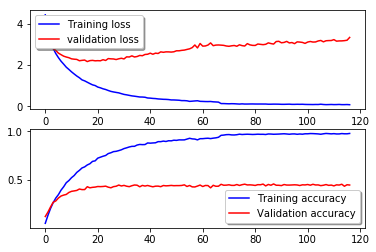

In [44]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(inception_history.history["acc"])
acc = inception_history.history["acc"][index_acc]
index_val_acc = np.argmax(inception_history.history["val_acc"])
val_acc = inception_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(inception_history.history["loss"])
losses = inception_history.history["loss"][index_loss]
index_val_loss = np.argmin(inception_history.history["val_loss"])
val_losses = inception_history.history["val_loss"][index_val_loss]

acc_saved = inception_history.history["acc"][index_val_loss]
val_acc_saved = inception_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = inception_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on InceptionV3
fig, ax = plt.subplots(2,1)
ax[0].plot(inception_history.history['loss'], color='b', label="Training loss")
ax[0].plot(inception_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inception_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(inception_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Xception

best train accuracy 0.9970530451866405 on epoch 70 
best validation accuracy 0.5071517412935324 on epoch 75 
lowest train loss 0.5811778635430664 on epoch 103 
lowest validation loss 2.1246034363609048 on epoch 16 
saved accuracy : 0.843320235756385, val accuracy : 0.46548507462686567, and train loss 0.5811778635430664 : 


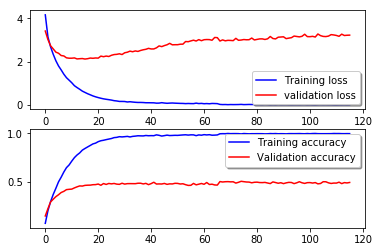

In [45]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(xception_history.history["acc"])
acc = xception_history.history["acc"][index_acc]
index_val_acc = np.argmax(xception_history.history["val_acc"])
val_acc = xception_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(xception_history.history["loss"])
losses = xception_history.history["loss"][index_loss]
index_val_loss = np.argmin(xception_history.history["val_loss"])
val_losses = xception_history.history["val_loss"][index_val_loss]

acc_saved = xception_history.history["acc"][index_val_loss]
val_acc_saved = xception_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = xception_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

#Plot the loss and accuracy curves for training and validation on xception model
fig, ax = plt.subplots(2,1)
ax[0].plot(xception_history.history['loss'], color='b', label="Training loss")
ax[0].plot(xception_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(xception_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(xception_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Resnet50

best train accuracy 0.9945972495088409 on epoch 108 
best validation accuracy 0.5783582089552238 on epoch 117 
lowest train loss 0.4157885669022506 on epoch 108 
lowest validation loss 1.6847976730830634 on epoch 18 
saved accuracy : 0.8823673870333988, val accuracy : 0.5494402985074627, and train loss 0.4157885669022506 : 


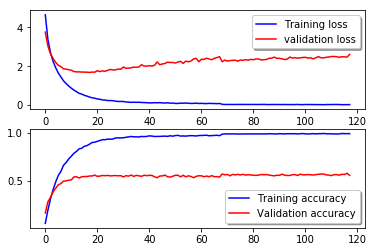

In [46]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(resnet_history.history["acc"])
acc = resnet_history.history["acc"][index_acc]
index_val_acc = np.argmax(resnet_history.history["val_acc"])
val_acc = resnet_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(resnet_history.history["loss"])
losses = resnet_history.history["loss"][index_loss]
index_val_loss = np.argmin(resnet_history.history["val_loss"])
val_losses = resnet_history.history["val_loss"][index_val_loss]

acc_saved = resnet_history.history["acc"][index_val_loss]
val_acc_saved = resnet_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = resnet_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on resnet model
fig, ax = plt.subplots(2,1)
ax[0].plot(resnet_history.history['loss'], color='b', label="Training loss")
ax[0].plot(resnet_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(resnet_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(resnet_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## VGG19

best train accuracy 0.9909135559921415 on epoch 63 
best validation accuracy 0.5208333333333334 on epoch 68 
lowest train loss 0.7837443582435488 on epoch 63 
lowest validation loss 2.0758746376085044 on epoch 9 
saved accuracy : 0.768786836935167, val accuracy : 0.48445273631840796, and train loss 0.7837443582435488 : 


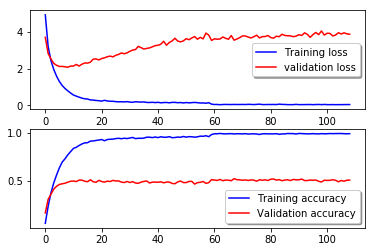

In [47]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(vgg_history.history["acc"])
acc = vgg_history.history["acc"][index_acc]
index_val_acc = np.argmax(vgg_history.history["val_acc"])
val_acc = vgg_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(vgg_history.history["loss"])
losses = vgg_history.history["loss"][index_loss]
index_val_loss = np.argmin(vgg_history.history["val_loss"])
val_losses = vgg_history.history["val_loss"][index_val_loss]

acc_saved = vgg_history.history["acc"][index_val_loss]
val_acc_saved = vgg_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = vgg_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on vgg model
fig, ax = plt.subplots(2,1)
ax[0].plot(vgg_history.history['loss'], color='b', label="Training loss")
ax[0].plot(vgg_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(vgg_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(vgg_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## InceptionResnet_V2

best train accuracy 0.9718811394891945 on epoch 123 
best validation accuracy 0.5021766169154229 on epoch 107 
lowest train loss 1.1097109505141882 on epoch 123 
lowest validation loss 2.2011135490379523 on epoch 23 
saved accuracy : 0.668713163064833, val accuracy : 0.43470149253731344, and train loss 1.1097109505141882 : 


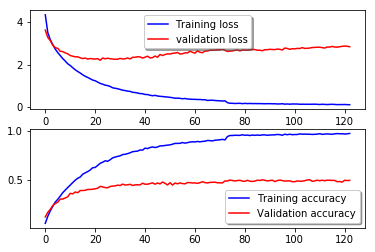

In [48]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(inceptionresnet_history.history["acc"])
acc = inceptionresnet_history.history["acc"][index_acc]
index_val_acc = np.argmax(inceptionresnet_history.history["val_acc"])
val_acc = inceptionresnet_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(inceptionresnet_history.history["loss"])
losses = inceptionresnet_history.history["loss"][index_loss]
index_val_loss = np.argmin(inceptionresnet_history.history["val_loss"])
val_losses = inceptionresnet_history.history["val_loss"][index_val_loss]

acc_saved = inceptionresnet_history.history["acc"][index_val_loss]
val_acc_saved = inceptionresnet_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = inceptionresnet_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on vgg model
fig, ax = plt.subplots(2,1)
ax[0].plot(inceptionresnet_history.history['loss'], color='b', label="Training loss")
ax[0].plot(inceptionresnet_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inceptionresnet_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(inceptionresnet_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# 3.4 Ensemble models

After fitting and eevaluating the models, now we ensemble all the models. 

### Load models with the highest accuracy results

In [49]:
from keras.models import load_model

inception_best = 'saved_models/inception.best.from_features.hdf5'
xception_best = 'saved_models/xception.best.from_features.hdf5'
resnet_best = 'saved_models/resnet.best.from_features.hdf5'
vgg_best = 'saved_models/vgg.best.from_features.hdf5'
inceptionresnet_best = 'saved_models/inceptionresnet.best.from_features.hdf5'

### Create Data sets for Ensemble model

In [50]:
incept = load_model(inception_best)
xcept = load_model(xception_best)
rest = load_model(resnet_best)
vg = load_model(vgg_best)
incres = load_model(inceptionresnet_best)

In [51]:
inc = incept.predict(inception_train_features, batch_size=32, verbose=1)
xce = xcept.predict(xception_train_features, batch_size=32, verbose=1)
res = rest.predict(resnet_train_features, batch_size=32, verbose=1)
vgg = vg.predict(vgg_train_features, batch_size=32, verbose=1)
incs = incres.predict(inceptionresnet_train_features, batch_size=32, verbose=1)


ensemble_train_features = np.concatenate((inc,xce,res,vgg,incs), axis = 1)

8144/8144 [==============================] - ETA: 31:0 - ETA: 5:0 - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 55s - ETA: 48 - ETA: 41 - ETA: 36 - ETA: 32 - ETA: 28 - ETA: 25 - ETA: 23 - ETA: 21 - ETA: 19 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 1ms/step


In [52]:
inc = incept.predict(inception_test_features, batch_size=32, verbose=1)
xce = xcept.predict(xception_test_features, batch_size=32, verbose=1)
res = rest.predict(resnet_test_features, batch_size=32, verbose=1)
vgg = vg.predict(vgg_test_features, batch_size=32, verbose=1)
incs = incres.predict(inceptionresnet_test_features, batch_size=32, verbose=1)


ensemble_test_features = np.concatenate((inc,xce,res,vgg,incs), axis = 1)

8041/8041 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 337us/step


In [53]:
ensemble_valid_x, ensemble_test_x, ensemble_valid_y, ensemble_test_y = train_test_split(ensemble_test_features, y_test, test_size=0.6, random_state=99)

## If you want to test the ensemble model, skip this training part below and move to Section 4

In [55]:
ensemble_model = Sequential()
ensemble_model.add(Dense(1024, activation='relu', input_shape= ensemble_train_features.shape[1:]))
ensemble_model.add(Dropout(0.5))
ensemble_model.add(Dense(512, activation='relu'))
ensemble_model.add(Dropout(0.2))
ensemble_model.add(Dense(n_class, activation='softmax'))

ensemble_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

ensemble_model.summary()

ensemble_callbacks=[TQDMNotebookCallback(),
                     reduce_lr,
                      ModelCheckpoint(filepath='saved_models/ensemble.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                     early_stopping
                     ]

ensemble_history = ensemble_model.fit(ensemble_train_features, y_train, 
                        validation_data=(ensemble_valid_x, ensemble_valid_y),
                        epochs=1000, 
                        callbacks=ensemble_callbacks,
                        class_weight=class_weights,
                        batch_size=32, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1024)              1004544   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 196)               100548    
Total params: 1,629,892
Trainable params: 1,629,892
Non-trainable params: 0
_________________________________________________________________



Epoch 00001: val_loss improved from inf to 1.54469, saving model to saved_models/ensemble.best.from_features.hdf5



Epoch 00002: val_loss did not improve from 1.54469



Epoch 00003: val_loss did not improve from 1.54469



Epoch 00004: val_loss did not improve from 1.54469



Epoch 00005: val_loss did not improve from 1.54469



Epoch 00006: val_loss did not improve from 1.54469



Epoch 00007: val_loss did not improve from 1.54469



Epoch 00008: val_loss did not improve from 1.54469



Epoch 00009: val_loss did not improve from 1.54469



Epoch 00010: val_loss did not improve from 1.54469



Epoch 00011: val_loss did not improve from 1.54469



Epoch 00012: val_loss did not improve from 1.54469



Epoch 00013: val_loss did not improve from 1.54469



Epoch 00014: val_loss did not improve from 1.54469



Epoch 00015: val_loss did not improve from 1.54469



Epoch 00016: val_loss did not improve from 1.54469



Epoch 00017: val_loss did not improve from 1.54469



Epoch 00018: val_loss did not improve from 1.54469



Epoch 00019: val_loss did not improve from 1.54469



Epoch 00020: val_loss did not improve from 1.54469



Epoch 00021: val_loss did not improve from 1.54469



Epoch 00022: val_loss did not improve from 1.54469



Epoch 00023: val_loss did not improve from 1.54469



Epoch 00024: val_loss did not improve from 1.54469



Epoch 00025: val_loss did not improve from 1.54469



Epoch 00026: val_loss did not improve from 1.54469



Epoch 00027: val_loss did not improve from 1.54469



Epoch 00028: val_loss did not improve from 1.54469



Epoch 00029: val_loss did not improve from 1.54469



Epoch 00030: val_loss did not improve from 1.54469



Epoch 00031: val_loss did not improve from 1.54469



Epoch 00032: val_loss did not improve from 1.54469



Epoch 00033: val_loss did not improve from 1.54469



Epoch 00034: val_loss did not improve from 1.54469



Epoch 00035: val_loss did not improve from 1.54469



Epoch 00036: val_loss did not improve from 1.54469



Epoch 00037: val_loss did not improve from 1.54469



Epoch 00038: val_loss did not improve from 1.54469



Epoch 00039: val_loss did not improve from 1.54469



Epoch 00040: val_loss did not improve from 1.54469



Epoch 00041: val_loss did not improve from 1.54469



Epoch 00042: val_loss did not improve from 1.54469



Epoch 00043: val_loss did not improve from 1.54469



Epoch 00044: val_loss did not improve from 1.54469



Epoch 00045: val_loss did not improve from 1.54469



Epoch 00046: val_loss did not improve from 1.54469



Epoch 00047: val_loss did not improve from 1.54469



Epoch 00048: val_loss did not improve from 1.54469



Epoch 00049: val_loss did not improve from 1.54469



Epoch 00050: val_loss did not improve from 1.54469



Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00051: val_loss did not improve from 1.54469



Epoch 00052: val_loss did not improve from 1.54469



Epoch 00053: val_loss did not improve from 1.54469



Epoch 00054: val_loss did not improve from 1.54469



Epoch 00055: val_loss did not improve from 1.54469



Epoch 00056: val_loss did not improve from 1.54469



Epoch 00057: val_loss did not improve from 1.54469



Epoch 00058: val_loss did not improve from 1.54469



Epoch 00059: val_loss did not improve from 1.54469



Epoch 00060: val_loss did not improve from 1.54469



Epoch 00061: val_loss did not improve from 1.54469



Epoch 00062: val_loss did not improve from 1.54469



Epoch 00063: val_loss did not improve from 1.54469



Epoch 00064: val_loss did not improve from 1.54469



Epoch 00065: val_loss did not improve from 1.54469



Epoch 00066: val_loss did not improve from 1.54469



Epoch 00067: val_loss did not improve from 1.54469



Epoch 00068: val_loss did not improve from 1.54469



Epoch 00069: val_loss did not improve from 1.54469



Epoch 00070: val_loss did not improve from 1.54469



Epoch 00071: val_loss did not improve from 1.54469



Epoch 00072: val_loss did not improve from 1.54469



Epoch 00073: val_loss did not improve from 1.54469



Epoch 00074: val_loss did not improve from 1.54469



Epoch 00075: val_loss did not improve from 1.54469



Epoch 00076: val_loss did not improve from 1.54469



Epoch 00077: val_loss did not improve from 1.54469



Epoch 00078: val_loss did not improve from 1.54469



Epoch 00079: val_loss did not improve from 1.54469



Epoch 00080: val_loss did not improve from 1.54469



Epoch 00081: val_loss did not improve from 1.54469



Epoch 00082: val_loss did not improve from 1.54469



Epoch 00083: val_loss did not improve from 1.54469



Epoch 00084: val_loss did not improve from 1.54469



Epoch 00085: val_loss did not improve from 1.54469



Epoch 00086: val_loss did not improve from 1.54469



Epoch 00087: val_loss did not improve from 1.54469



Epoch 00088: val_loss did not improve from 1.54469



Epoch 00089: val_loss did not improve from 1.54469



Epoch 00090: val_loss did not improve from 1.54469



Epoch 00091: val_loss did not improve from 1.54469



Epoch 00092: val_loss did not improve from 1.54469



Epoch 00093: val_loss did not improve from 1.54469



Epoch 00094: val_loss did not improve from 1.54469



Epoch 00095: val_loss did not improve from 1.54469



Epoch 00096: val_loss did not improve from 1.54469



Epoch 00097: val_loss did not improve from 1.54469



Epoch 00098: val_loss did not improve from 1.54469



Epoch 00099: val_loss did not improve from 1.54469



Epoch 00100: val_loss did not improve from 1.54469



Epoch 00101: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00101: val_loss did not improve from 1.54469
Epoch 00101: early stopping


best train accuracy 0.9985265225933202 on epoch 66 
best validation accuracy 0.6654228855721394 on epoch 10 
lowest train loss 1.5824227457196398 on epoch 86 
lowest validation loss 1.544690114348682 on epoch 1 
saved accuracy : 0.8043958742632613, val accuracy : 0.6526741293532339, and train loss 1.5824227457196398 : 


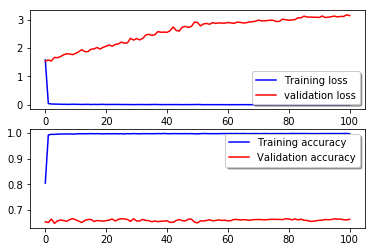

In [56]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss

index_acc = np.argmax(ensemble_history.history["acc"])
acc = ensemble_history.history["acc"][index_acc]
index_val_acc = np.argmax(ensemble_history.history["val_acc"])
val_acc = ensemble_history.history["val_acc"][index_val_acc]

index_loss = np.argmin(ensemble_history.history["loss"])
losses = ensemble_history.history["loss"][index_loss]
index_val_loss = np.argmin(ensemble_history.history["val_loss"])
val_losses = ensemble_history.history["val_loss"][index_val_loss]

acc_saved = ensemble_history.history["acc"][index_val_loss]
val_acc_saved = ensemble_history.history["val_acc"][index_val_loss]
train_loss_saved = losses = ensemble_history.history["loss"][index_val_loss]

print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

# Plot the loss and accuracy curves for training and validation on vgg model
fig, ax = plt.subplots(2,1)
ax[0].plot(ensemble_history.history['loss'], color='b', label="Training loss")
ax[0].plot(ensemble_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(ensemble_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(ensemble_history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# 4. Testing model's performance

## 4.1 Confusion Matrix, Precision-Recall, AUC ROC Curve

Confusion matrix can check false positives for each labels. This can visualize bias and variance of the model's prediction.

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. See [HERE](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) for more info.

I validate the models using Test data.

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

### InceptionV3

Average precision score, micro-averaged over all classes: 0.44
ROC AUC Score:  0.9797914166640158


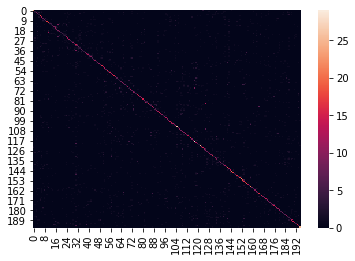

In [58]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = incept.predict(X_test_inception)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_inception,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_inception[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_inception[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_inception.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_inception, Y_pred,
                                                     average="micro")

print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_inception, Y_pred)

print("ROC AUC Score: ", roc_score)

### Xception

Average precision score, micro-averaged over all classes: 0.49
ROC AUC Score:  0.9818310213629583


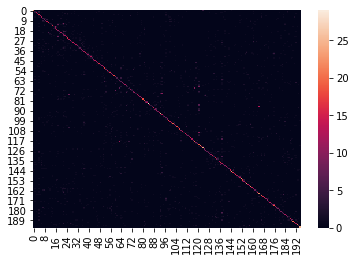

In [59]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = xcept.predict(X_test_xception)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_xception,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_xception[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_xception[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_xception.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_xception, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_xception, Y_pred)

print("ROC AUC Score: ", roc_score)

### Resnet50

Average precision score, micro-averaged over all classes: 0.60
ROC AUC Score:  0.9881062436197849


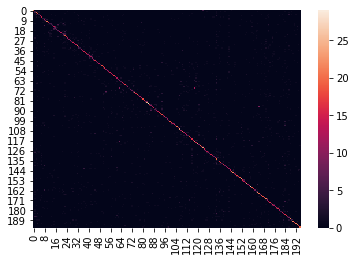

In [60]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = rest.predict(X_test_resnet)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_resnet,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_resnet[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_resnet[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_resnet.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_resnet, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_resnet, Y_pred)

print("ROC AUC Score: ", roc_score)

### VGG19

Average precision score, micro-averaged over all classes: 0.50
ROC AUC Score:  0.9804592102555139


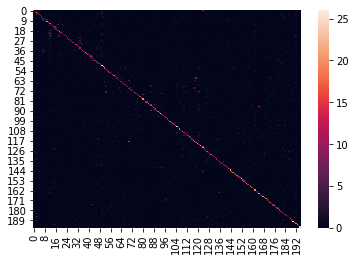

In [61]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = vg.predict(X_test_vgg)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_vgg,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_vgg[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_vgg[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_vgg.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_vgg, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_vgg, Y_pred)

print("ROC AUC Score: ", roc_score)

## InceptionResnetV2

Average precision score, micro-averaged over all classes: 0.44
ROC AUC Score:  0.9779196166957363


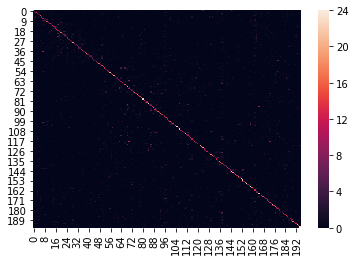

In [62]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = incres.predict(X_test_inceptionresnet)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_inceptionresnet,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test_inceptionresnet[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_inceptionresnet[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_inceptionresnet.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test_inceptionresnet, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test_inceptionresnet, Y_pred)

print("ROC AUC Score: ", roc_score)

## Ensemble Model - The Final Model

In [63]:
# Load best saved model for ensemble model

ensemble = load_model("saved_models/ensemble.best.from_features.hdf5")

Average precision score, micro-averaged over all classes: 0.71
ROC AUC Score:  0.9858937449500644


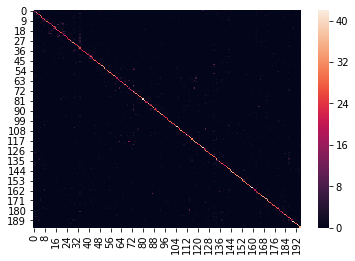

In [84]:
# Look at confusion matrix 

# Predict the values from the validation dataset
Y_pred = ensemble.predict(ensemble_test_features)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
ax = sns.heatmap(confusion_mtx)

#Calculating Precision-Recall Score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(196):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

#Calculating ROC AUC Score

roc_score = roc_auc_score(y_test, Y_pred)

print("ROC AUC Score: ", roc_score)

## 4.2 Results Summary

The results can be slightly change if we re-train the model

#### 1. Inception

*Classification Accuracy: 0.6966 (train), 0.4229 (validation)

*Loss error             : 1.2172 (train), 2.1878 (validation)

*Average precision score, micro-averaged over all classes: 0.44

*ROC AUC Score:  0.9790820458637852

#### 2. Xception

*Classification Accuracy: 0.8115 (train), 0.4652 (validation)

*Loss error             : 0.6989 (train), 2.1083 (validation)

*Average precision score, micro-averaged over all classes: 0.50

*ROC AUC Score:  0.9824882943932024

#### 3. Resnet50

*Classification Accuracy: 0.8886 (train), 0.5572 (validation)

*Loss error             : 0.4049 (train), 1.7131 (validation)

*Average precision score, micro-averaged over all classes: 0.59

*ROC AUC Score:  0.9869771002900094

#### 4. VGG19

*Classification Accuracy: 0.7349 (train), 0.4773 (validation)

*Loss error             : 0.8825 (train), 2.1087 (validation)

*Average precision score, micro-averaged over all classes: 0.48

*ROC AUC Score:  0.9796499374539075

#### 5. InceptionResnet

*Classification Accuracy: 0.6971 (train), 0.4344 (validation)

*Loss error             : 1.0177 (train), 2.2085 (validation)

*Average precision score, micro-averaged over all classes: 0.44

*ROC AUC Score:  0.9774902336172602

### 6. Ensemble Model

*Classification Accuracy: 0.9905 (train), 0.6576 (validation)

*Loss error             : 0.0490 (train), 1.5401 (validation)

*Average precision score, micro-averaged over all classes: 0.70

*ROC AUC Score:  0.9813272164290486




It shows that Ensemble Model obtained significant improvement over others